In [97]:
# Behavior × Photometry Correlations with MCC and Between-Genotype Δr Tests
# ------------
# 1) Per Genotype × Stage panels:
#    - Pearson r, p_raw, p_adj (FDR-BH or Bonferroni), and N per Behavior×Photometry cell
#    - Heatmaps (CMAP) with stars only for p_adj < alpha
#    - Cell annotation: r (top) and N (bottom)

# 2) Between-genotype (WT vs KO) per Stage:
#    - Δr = r_WT − r_KO  (signed, **NOT** absolute)
#    - Fisher r-to-z difference test using N_WT and N_KO per cell
#    - p_raw_diff and p_adj_diff (MCC), stars only for p_adj_diff < alpha
#    - Heatmaps (CMAP_DIFF) with symmetric limits around 0

# 3) One Excel file with:
#    - Cleaned data
#    - For each (Genotype, Stage): r, p_raw, p_adj, N
#    - For each Stage: Δr, p_raw_diff, p_adj_diff, sig_mask

# Notes
# -----
# - For small N or |r|≈1, Fisher z can be unstable; the code guards with NaNs when N<=3 or |r|>=0.999999.
# - FDR is applied **within each matrix** (panel or stage Δ test), not across all stages/panels.
# - If you want an explicit stage order, set STAGE_ORDER below.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, norm


PARAMETERS  

In [98]:
EXCEL_PATH = r"Z:\UriMons\Modulation_Index\Photometry&Behavior\Raw_data.xlsx"  # change to your path
SHEET_NAME = 0  # or "Sheet1"

BEHAVIOR   = ["GroomingTime", "GroomingBouts"] # remove any variable you don't want in the analysis: removed "TimePerBout"
PHOTOMETRY = ["Events", "AUC"] # removed "Amplitude"

GENOTYPES  = ["WT", "KO"]            # expected genotypes
ALPHA      = 0.05                    # significance level (after MCC)
MCC_METHOD = "fdr_bh"                # "fdr_bh", "bonferroni", or "none"

CMAP       = "coolwarm"              # e.g. 'RdBu_r', 'bwr', 'seismic', 'BrBG'
CMAP_DIFF  = "RdBu_r"                # diverging for Δr (WT−KO)

# Optional: enforce a specific stage order; otherwise will sort by string
STAGE_ORDER = None  # e.g., ["Baseline", "EPA", "Post"] or None to auto-sort

# Output Excel (kept generic so the source filename isn't prefixed)
OUT_DIR   = os.path.dirname(EXCEL_PATH)
OUT_XLSX  = os.path.join(OUT_DIR, "behavior_photometry_analysis.xlsx")


UTILITIES   

In [99]:
def fdr_bh(pvals_1d: np.ndarray) -> np.ndarray:
    """Benjamini–Hochberg FDR; returns adjusted p-values in original order."""
    p = np.asarray(pvals_1d, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    q = ranked * n / (np.arange(1, n + 1))
    q = np.minimum.accumulate(q[::-1])[::-1]
    q = np.clip(q, 0, 1)
    out = np.empty_like(q)
    out[order] = q
    return out

def apply_mcc_matrix(p_df: pd.DataFrame, method: str, alpha: float):
    """
    Apply MCC to a rectangular p-value matrix (any shape).
    Returns: p_adj_df, sig_mask_df (p_adj<alpha).
    Correction is across ALL finite cells in the matrix.
    """
    p = p_df.values
    mask = np.isfinite(p)
    p_adj = np.full_like(p, np.nan, dtype=float)

    if method == "none":
        p_adj[mask] = p[mask]
    elif method == "bonferroni":
        m = mask.sum()
        factor = max(m, 1)
        p_adj[mask] = np.clip(p[mask] * factor, 0, 1)
    elif method == "fdr_bh":
        if mask.any():
            p_adj_vals = fdr_bh(p[mask])
            p_adj[mask] = p_adj_vals
    else:
        raise ValueError(f"Unknown MCC method: {method}")

    p_adj_df = pd.DataFrame(p_adj, index=p_df.index, columns=p_df.columns)
    sig = (p_adj_df < alpha)
    sig = sig.fillna(False)
    return p_adj_df, sig

def corr_block(df_sub: pd.DataFrame,
               beh_cols: list, pho_cols: list) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Compute r, p_raw, and N matrices for all Behavior×Photometry pairs in df_sub.
    df_sub is typically one (Genotype, Stage) subset with rows = mice.
    """
    r_mat   = pd.DataFrame(index=beh_cols, columns=pho_cols, dtype=float)
    p_mat   = pd.DataFrame(index=beh_cols, columns=pho_cols, dtype=float)
    n_mat   = pd.DataFrame(index=beh_cols, columns=pho_cols, dtype=int)

    for b in beh_cols:
        for p in pho_cols:
            xy = df_sub[[b, p]].dropna()
            n = len(xy)
            if n >= 3:
                r, pv = pearsonr(xy[b], xy[p])
            else:
                r, pv = np.nan, np.nan
            r_mat.loc[b, p] = r
            p_mat.loc[b, p] = pv
            n_mat.loc[b, p] = n
    return r_mat, p_mat, n_mat

def fisher_diff_p(r1, n1, r2, n2):
    """
    Fisher r-to-z difference test for two independent correlations.
    Returns p-value (two-sided). If inputs invalid, returns NaN.
    """
    if n1 is None or n2 is None or n1 <= 3 or n2 <= 3:
        return np.nan
    if not np.isfinite(r1) or not np.isfinite(r2):
        return np.nan
    r1 = np.clip(r1, -0.999999, 0.999999)
    r2 = np.clip(r2, -0.999999, 0.999999)
    z1 = 0.5 * np.log((1 + r1) / (1 - r1))
    z2 = 0.5 * np.log((1 + r2) / (1 - r2))
    se = np.sqrt(1.0 / (n1 - 3) + 1.0 / (n2 - 3))
    if se <= 0 or not np.isfinite(se):
        return np.nan
    z = (z1 - z2) / se
    p = 2.0 * (1.0 - norm.cdf(abs(z)))
    return p

def text_stars(p):
    if not np.isfinite(p):
        return ""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

LOAD & CLEAN

In [100]:
df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
df.columns = df.columns.str.strip()

required = ["Mouse", "Genotype", "Stage"]
expected = required + BEHAVIOR + PHOTOMETRY
missing = [c for c in expected if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# Keep only needed, in the expected order that exists
df = df[[c for c in expected if c in df.columns]].copy()

# Normalize categorials
df["Mouse"]    = df["Mouse"].astype(str).str.strip()
df["Genotype"] = df["Genotype"].astype(str).str.strip()
df["Stage"]    = df["Stage"].astype(str).str.strip()

# Filter to declared genotypes (avoid typos sneaking in)
df = df[df["Genotype"].isin(GENOTYPES)].copy()

# Force numeric for metrics; track NaNs created
nan_before = {c: int(df[c].isna().sum()) for c in BEHAVIOR + PHOTOMETRY}
for c in BEHAVIOR + PHOTOMETRY:
    df[c] = pd.to_numeric(df[c], errors="coerce")
nan_after = {c: int(df[c].isna().sum()) for c in BEHAVIOR + PHOTOMETRY}
print("[NaN counts after numeric coercion]:", {c: nan_after[c] for c in BEHAVIOR + PHOTOMETRY})

# Aggregate duplicates (Mouse×Stage) by mean (defensive)
dupes = df.duplicated(subset=["Mouse", "Stage"], keep=False)
if dupes.any():
    print(f"[WARN] Found {dupes.sum()} duplicate rows by Mouse×Stage; aggregating by mean.")
    df = (
        df.groupby(["Mouse", "Genotype", "Stage"], as_index=False)[BEHAVIOR + PHOTOMETRY]
        .mean()
    )

# Stage order
if STAGE_ORDER:
    present = [s for s in STAGE_ORDER if s in df["Stage"].unique()]
    stages = present
else:
    stages = sorted(df["Stage"].dropna().unique(), key=lambda x: str(x))


[NaN counts after numeric coercion]: {'GroomingTime': 4, 'GroomingBouts': 4, 'Events': 0, 'AUC': 0}


PER-GENOTYPE×STAGE CORRELATIONS

In [101]:
r_panels   = {}  # (geno, stage) -> DataFrame r
praw_panels= {}  # (geno, stage) -> DataFrame p_raw
padj_panels= {}  # (geno, stage) -> DataFrame p_adj
N_panels   = {}  # (geno, stage) -> DataFrame N
sig_panels = {}  # (geno, stage) -> DataFrame bool

for g in GENOTYPES:
    dfg = df[df["Genotype"] == g]
    if dfg.empty:
        continue
    for st in stages:
        dfs = dfg[dfg["Stage"] == st]
        if dfs.empty:
            # still register empty matrices for consistent plotting
            r_mat   = pd.DataFrame(np.nan, index=BEHAVIOR, columns=PHOTOMETRY)
            p_mat   = r_mat.copy()
            n_mat   = pd.DataFrame(0,     index=BEHAVIOR, columns=PHOTOMETRY)
        else:
            r_mat, p_mat, n_mat = corr_block(dfs, BEHAVIOR, PHOTOMETRY)

        p_adj, sig = apply_mcc_matrix(p_mat, MCC_METHOD, ALPHA)

        key = (g, st)
        r_panels[key]    = r_mat
        praw_panels[key] = p_mat
        padj_panels[key] = p_adj
        N_panels[key]    = n_mat
        sig_panels[key]  = sig

c:\Users\urimons.WISMAIN\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\urimons.WISMAIN\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\urimons.WISMAIN\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\urimons.WISMAIN\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


PLOTTING: r

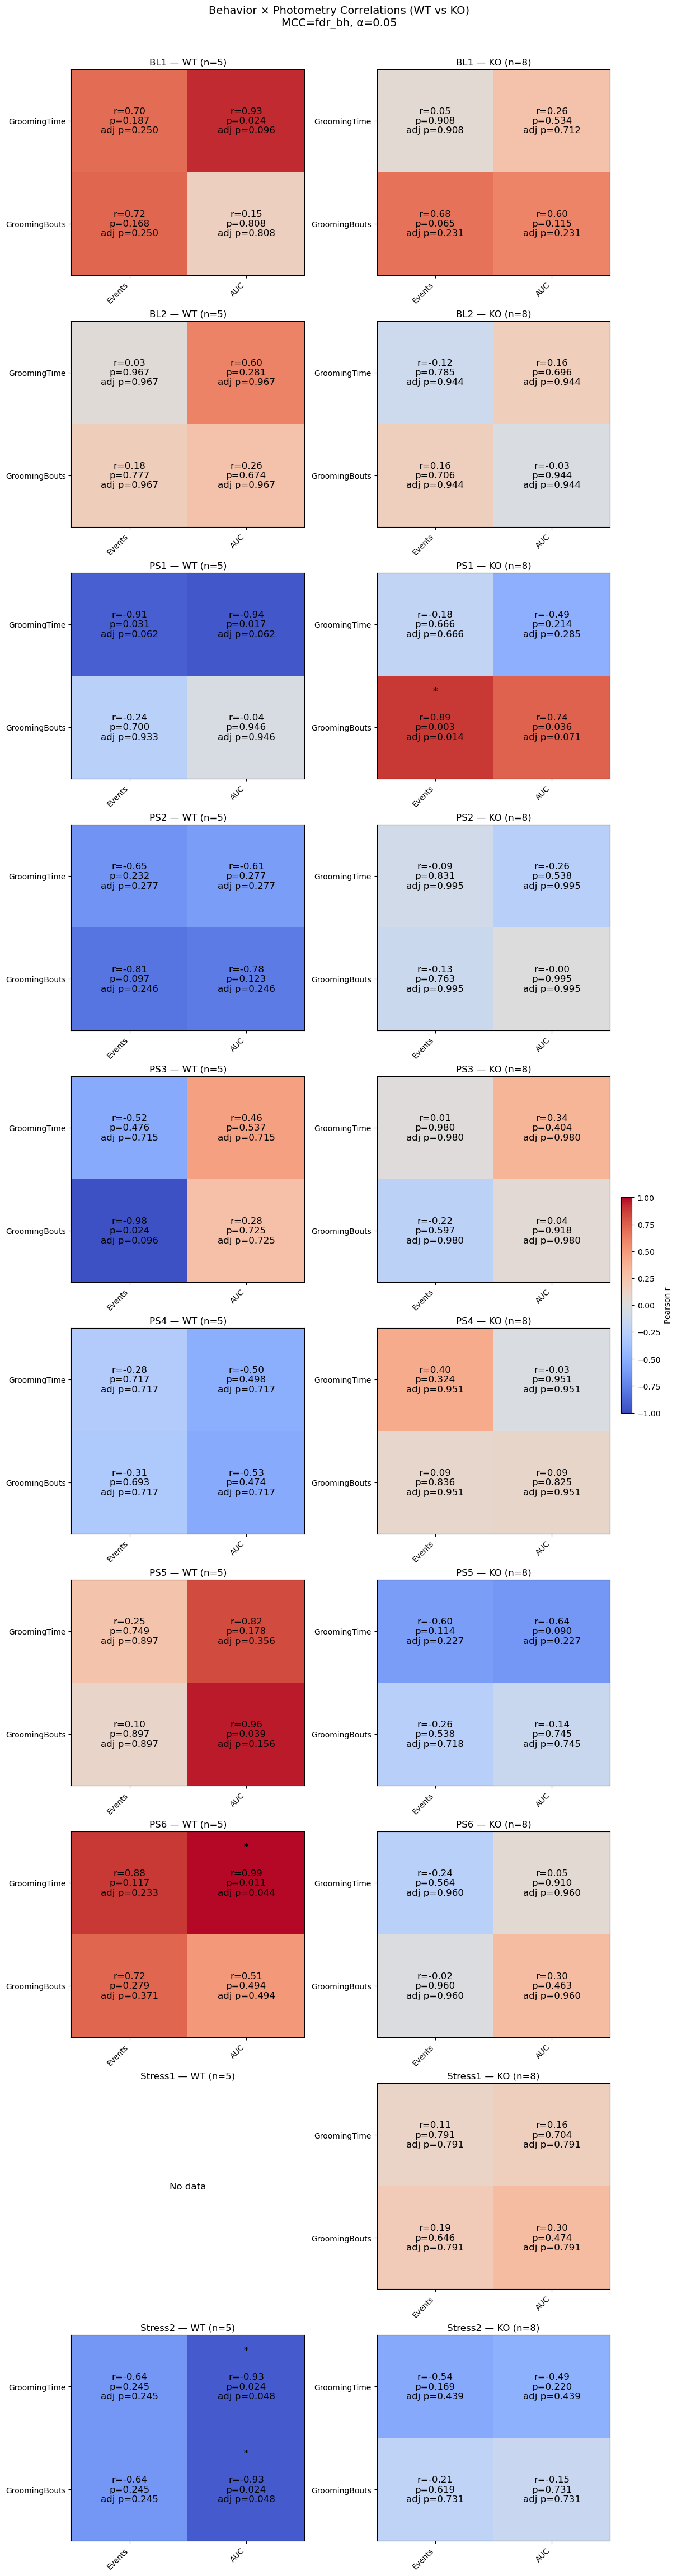

In [102]:
n_stages = len(stages)
fig, axes = plt.subplots(n_stages, 2, figsize=(12, 4.5 * n_stages), constrained_layout=True)
if n_stages == 1:
    axes = np.array([axes])  # ensure 2D indexable

last_im = None
for i, st in enumerate(stages):
    for j, g in enumerate(GENOTYPES):
        ax = axes[i, j]
        key   = (g, st)
        r_mat = r_panels.get(key)
        p_adj = padj_panels.get(key)

        # group size = number of unique mice in this Genotype×Stage
        n_total = int(df[(df["Genotype"] == g) & (df["Stage"] == st)]["Mouse"].nunique())

        ax.set_title(f"{st} — {g} (n={n_total})")
        if r_mat is None or np.all(np.isnan(r_mat.values)):
            ax.axis("off")
            ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
            continue

        last_im = ax.imshow(r_mat.values, vmin=-1, vmax=1, aspect="auto", cmap=CMAP)
        ax.set_xticks(range(len(PHOTOMETRY))); ax.set_xticklabels(PHOTOMETRY, rotation=45, ha="right")
        ax.set_yticks(range(len(BEHAVIOR)));   ax.set_yticklabels(BEHAVIOR)

        # annotate each cell with r, raw p (top), and adjusted p (bottom)
        for ii in range(r_mat.shape[0]):
            for jj in range(r_mat.shape[1]):
                r_val  = r_mat.iat[ii, jj]
                p_raw  = praw_panels[key].iat[ii, jj] if key in praw_panels else np.nan
                p_adjv = p_adj.iat[ii, jj] if p_adj is not None else np.nan
                if np.isfinite(r_val):
                    text_lines = [
                        f"r={r_val:.2f}",
                        f"p={p_raw:.3f}" if np.isfinite(p_raw) else "p=NA",
                        f"adj p={p_adjv:.3f}" if np.isfinite(p_adjv) else "adj p=NA"
                    ]
                    ax.text(jj, ii, "\n".join(text_lines),
                            ha="center", va="center", color="black", fontsize=12)


        # stars for significant cells — place them at the top of the cell
        for ii in range(r_mat.shape[0]):
            for jj in range(r_mat.shape[1]):
                pval = p_adj.iat[ii, jj]
                if np.isfinite(pval) and pval < ALPHA:
                    star = text_stars(pval)
                    if star:
                        # y offset moves star upward (smaller value = higher)
                        ax.text(jj, ii - 0.35, star,
                                ha='center', va='center',
                                color='black', fontsize=12, fontweight='bold')

# Shared colorbar
if last_im is not None:
    cbar = fig.colorbar(last_im, ax=axes, orientation="vertical", fraction=0.02, pad=0.02)
    cbar.set_label("Pearson r")

plt.suptitle(f"Behavior × Photometry Correlations (WT vs KO)\nMCC={MCC_METHOD}, α={ALPHA}", fontsize=14, y=1.02)
plt.show()


BETWEEN-GENOTYPE Δr (WT − KO)

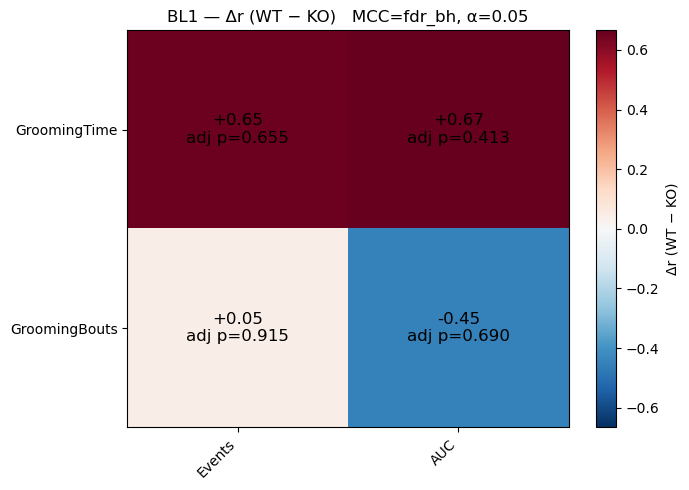

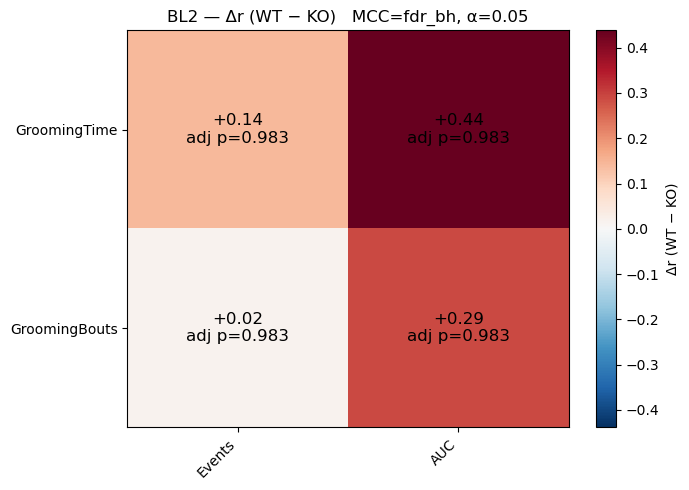

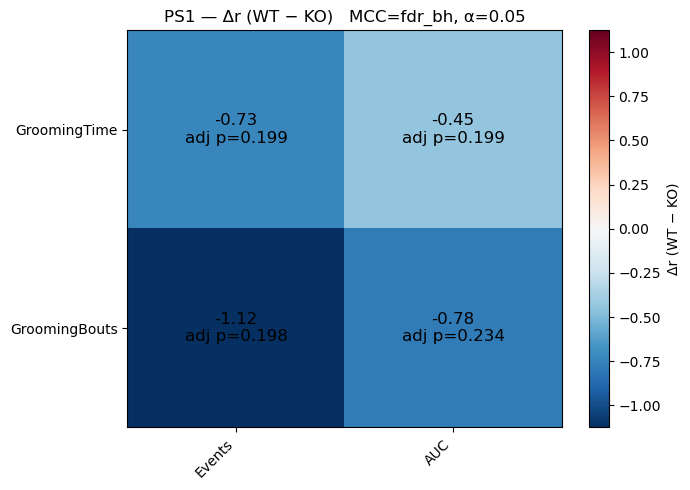

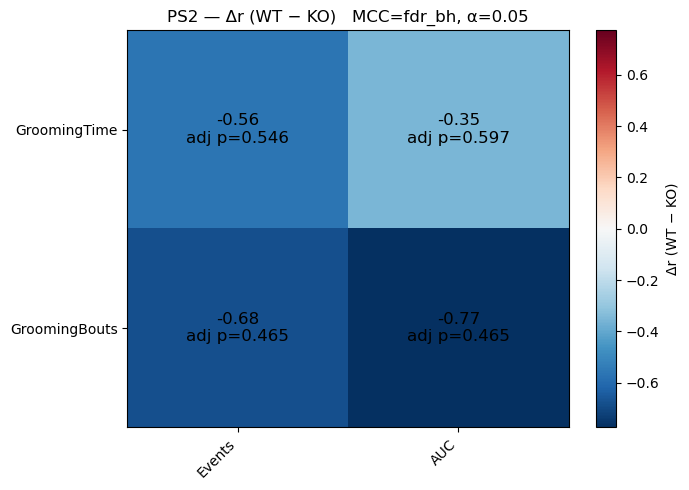

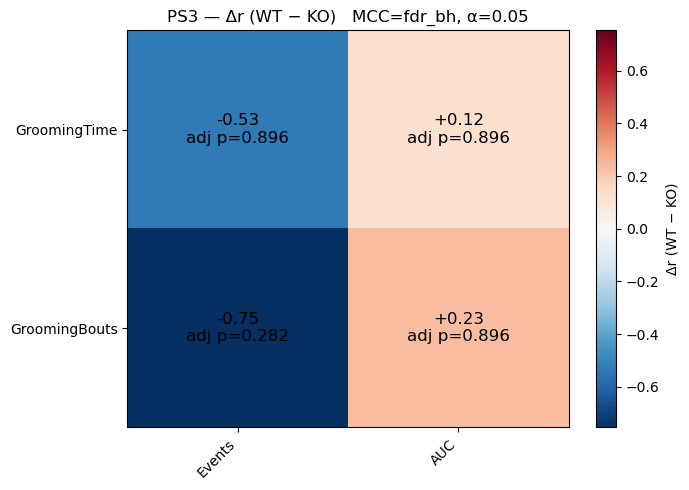

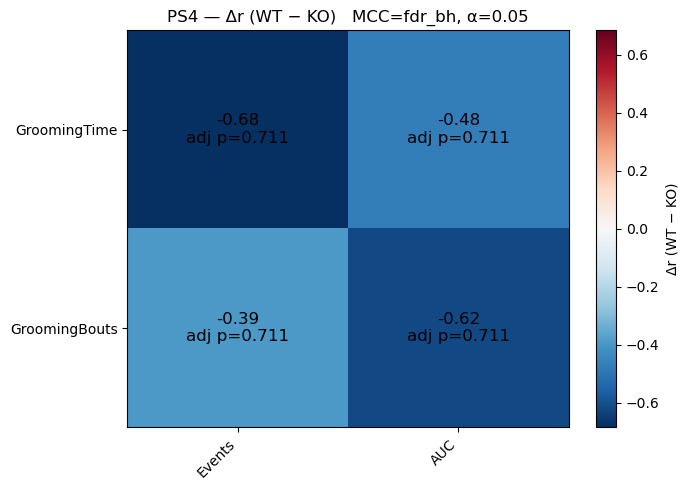

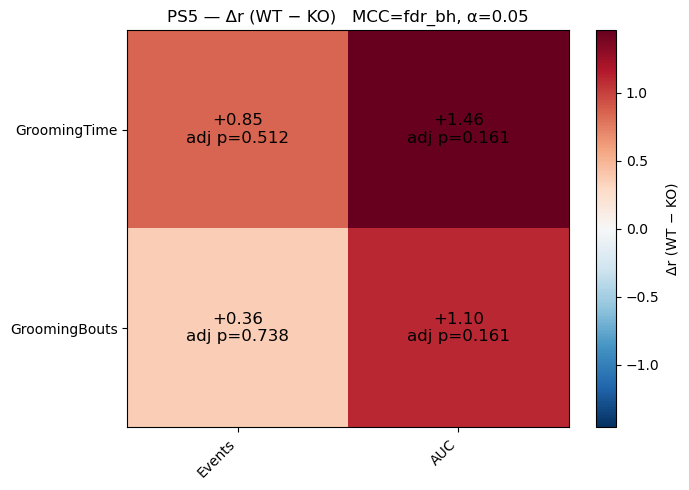

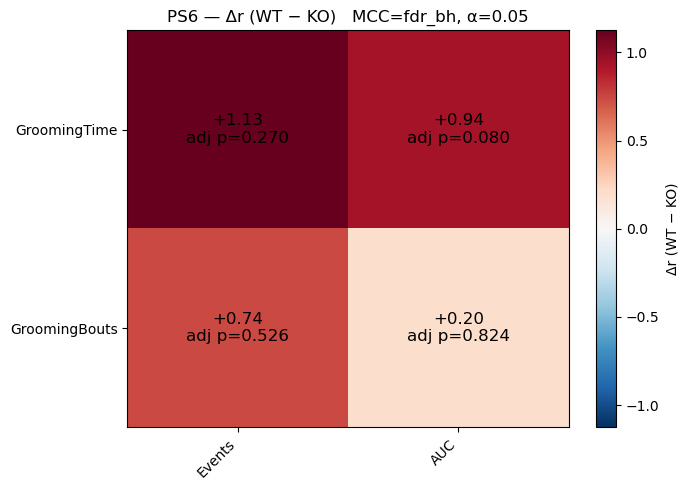

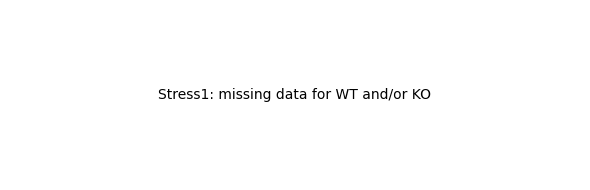

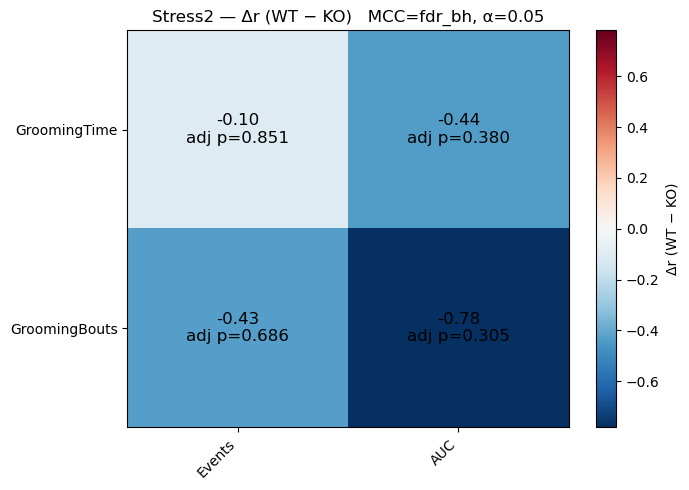

In [103]:
for st in stages:
    key_wt = ("WT", st)
    key_ko = ("KO", st)
    r_wt   = r_panels.get(key_wt)
    r_ko   = r_panels.get(key_ko)
    n_wt   = N_panels.get(key_wt)
    n_ko   = N_panels.get(key_ko)

    if r_wt is None or r_ko is None or r_wt.isna().all().all() or r_ko.isna().all().all():
        fig, ax = plt.subplots(figsize=(6, 2))
        ax.axis("off")
        ax.text(0.5, 0.5, f"{st}: missing data for WT and/or KO", ha="center", va="center")
        plt.tight_layout()
        plt.show()
        continue

    # Align and compute Δr = r_WT − r_KO (signed)
    r_wt = r_wt.reindex(index=BEHAVIOR, columns=PHOTOMETRY)
    r_ko = r_ko.reindex(index=BEHAVIOR, columns=PHOTOMETRY)
    n_wt = n_wt.reindex(index=BEHAVIOR, columns=PHOTOMETRY)
    n_ko = n_ko.reindex(index=BEHAVIOR, columns=PHOTOMETRY)

    delta_r = r_wt - r_ko

    # Fisher r-to-z difference test per cell using its own N_wt and N_ko
    p_diff = pd.DataFrame(np.nan, index=BEHAVIOR, columns=PHOTOMETRY)
    for i_b, b in enumerate(BEHAVIOR):
        for j_p, p in enumerate(PHOTOMETRY):
            pval = fisher_diff_p(r_wt.iat[i_b, j_p], n_wt.iat[i_b, j_p],
                                 r_ko.iat[i_b, j_p], n_ko.iat[i_b, j_p])
            p_diff.iat[i_b, j_p] = pval

    # Multiple-comparison correction (adjusted p-values)
    p_diff_adj, sig_diff = apply_mcc_matrix(p_diff, MCC_METHOD, ALPHA)

    # Plot Δr heatmap with stars (after MCC)
    vmax = np.nanmax(np.abs(delta_r.values))
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 1.0
    vmin = -vmax

    fig, ax = plt.subplots(figsize=(7, 5))
    im = ax.imshow(delta_r.values, vmin=vmin, vmax=vmax, cmap=CMAP_DIFF, aspect="auto")
    ax.set_xticks(range(len(PHOTOMETRY))); ax.set_xticklabels(PHOTOMETRY, rotation=45, ha="right")
    ax.set_yticks(range(len(BEHAVIOR)));   ax.set_yticklabels(BEHAVIOR)
    ax.set_title(f"{st} — Δr (WT − KO)   MCC={MCC_METHOD}, α={ALPHA}")

    # annotate Δr and adjusted p-value in each cell
    for i in range(delta_r.shape[0]):
        for j in range(delta_r.shape[1]):
            val     = delta_r.iat[i, j]
            p_adj_v = p_diff_adj.iat[i, j]
            if np.isfinite(val):
                if np.isfinite(p_adj_v):
                    ax.text(j, i,
                            f"{val:+.2f}\nadj p={p_adj_v:.3f}",
                            ha="center", va="center",
                            color="black", fontsize=12)
                else:
                    ax.text(j, i,
                            f"{val:+.2f}\nadj p=NA",
                            ha="center", va="center",
                            color="black", fontsize=9)

    # stars for p_adj_diff (place at top of cell)
    for i in range(delta_r.shape[0]):
        for j in range(delta_r.shape[1]):
            pv = p_diff_adj.iat[i, j]
            if np.isfinite(pv) and pv < ALPHA:
                star = text_stars(pv)
                if star:
                    ax.text(j, i - 0.35, star,   # small upward offset
                            ha='center', va='center',
                            color='black', fontsize=12, fontweight='bold')

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Δr (WT − KO)")
    plt.tight_layout()
    plt.show()


In [104]:
# Figure Legend (brief and clear)

# Figure X. Between-genotype differences in behavior–photometry correlations.
# For each behavioral variable and photometry measure, Pearson correlation coefficients were computed separately for WT and KO mice within each experimental stage.
# The difference in correlation strength between genotypes is shown as where positive values indicate stronger coupling in WT and negative values
# indicate stronger coupling in KO. Statistical comparison of the two independent correlations was performed using a Fisher r-to-z transformation with a z-test that
# incorporates the sample size contributing to each correlation (N).
# Resulting p-values were corrected for multiple comparisons using the specified method (FDR or Bonferroni).
#     Cells are annotated with Δr and the adjusted p-value, and significance is indicated by asterisks (* p < 0.05, ** p < 0.01, *** p < 0.001 after correction).
# This analysis identifies genotype-dependent changes in the strength and direction of behavior–photometry coupling across experimental stages.

EXCEL EXPORT

In [105]:
with pd.ExcelWriter(OUT_XLSX, engine="openpyxl") as w:
    df.to_excel(w, sheet_name="clean_data", index=False)

    # per panel
    for g in GENOTYPES:
        for st in stages:
            key = (g, st)
            if key not in r_panels:  # skip if genotype entirely absent
                continue
            # Build a tidy table for this panel
            r_tab   = r_panels[key].stack().rename("r").reset_index().rename(columns={"level_0":"Behavior","level_1":"Photometry"})
            p_raw   = praw_panels[key].stack().rename("p_raw").reset_index(drop=True)
            p_adj   = padj_panels[key].stack().rename("p_adj").reset_index(drop=True)
            n_tab   = N_panels[key].stack().rename("N").reset_index(drop=True)
            tidy    = pd.concat([r_tab, p_raw, p_adj, n_tab], axis=1)
            tidy.insert(0, "Genotype", g)
            tidy.insert(1, "Stage", st)

            sheet = f"{g}_{st}"[:31]
            tidy.to_excel(w, sheet_name=f"panel_{sheet}", index=False)

    # Δr per stage
    for st in stages:
        key_wt = ("WT", st)
        key_ko = ("KO", st)
        if key_wt not in r_panels or key_ko not in r_panels:
            continue

        r_wt = r_panels[key_wt].reindex(index=BEHAVIOR, columns=PHOTOMETRY)
        r_ko = r_panels[key_ko].reindex(index=BEHAVIOR, columns=PHOTOMETRY)
        n_wt = N_panels[key_wt].reindex(index=BEHAVIOR, columns=PHOTOMETRY)
        n_ko = N_panels[key_ko].reindex(index=BEHAVIOR, columns=PHOTOMETRY)

        delta_r = (r_wt - r_ko).stack().rename("delta_r").reset_index().rename(columns={"level_0":"Behavior","level_1":"Photometry"})

        # recompute p_diff and p_diff_adj to record them in Excel
        p_diff = pd.DataFrame(np.nan, index=BEHAVIOR, columns=PHOTOMETRY)
        for i_b, b in enumerate(BEHAVIOR):
            for j_p, p in enumerate(PHOTOMETRY):
                p_diff.iat[i_b, j_p] = fisher_diff_p(r_wt.iat[i_b, j_p], n_wt.iat[i_b, j_p],
                                                     r_ko.iat[i_b, j_p], n_ko.iat[i_b, j_p])
        p_diff_adj, sig_diff = apply_mcc_matrix(p_diff, MCC_METHOD, ALPHA)

        p_raw_tab = p_diff.stack().rename("p_raw_diff").reset_index(drop=True)
        p_adj_tab = p_diff_adj.stack().rename("p_adj_diff").reset_index(drop=True)
        sig_tab   = sig_diff.stack().rename("sig_adj").reset_index(drop=True)

        tidy = pd.concat([delta_r, p_raw_tab, p_adj_tab, sig_tab], axis=1)
        tidy.insert(0, "Stage", st)

        sheet = f"delta_{st}"[:31]
        tidy.to_excel(w, sheet_name=sheet, index=False)

print(f"[OK] Wrote analysis workbook: {OUT_XLSX}")

[OK] Wrote analysis workbook: Z:\UriMons\Modulation_Index\Photometry&Behavior\behavior_photometry_analysis.xlsx
